<a href="https://colab.research.google.com/github/pierrelabendzki/Text_Complexity/blob/main/Semantic_Complexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing Librairies

In [ ]:
pip install pydub

In [ ]:
#pip install whisper-timestamped

In [ ]:
#!pip install whisperx==3.1.1

In [ ]:
pip install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 17.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803321 sha256=d3d5201ee4a4b8ce6cd6b3e6d5afd57f22f878e837ec99b89160254ed47182e6
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [ ]:
!pip install git+https://github.com/m-bain/whisperx.git

  Cloning https://github.com/m-bain/whisperx.git to /tmp/pip-req-build-6y62k54i
  Running command git clone --filter=blob:none --quiet https://github.com/m-bain/whisperx.git /tmp/pip-req-build-6y62k54i
  Resolved https://github.com/m-bain/whisperx.git to commit 9e3a9e0e38fcec1304e1784381059a0e2c670be5
  Preparing metadata (setup.py) ... done


In [ ]:
pip install syllables

In [ ]:
pip install pylzma

  Using cached pylzma-0.5.0.tar.gz (4.2 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pylzma: filename=pylzma-0.5.0-cp310-cp310-linux_x86_64.whl size=222324 sha256=c6482cb875ae6a84ac056c18e055f978b24f70a6e8e4986dae985500196a421a
  Stored in directory: /root/.cache/pip/wheels/74/c9/02/91112815e838f544c1d46fda071241e454694579d022751d2b
Successfully built pylzma


Mount drive

In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
os.mkdir('Temp_Folder')

If you want to import your google drive

In [ ]:
drive.mount('/content/gdrive')

#Inporting librairies

In [ ]:
import os
# import librosa
from pydub.utils import mediainfo
#import audiotools
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile as io
import math
import json
import re


import whisper
#import whisper_timestamped
import whisperx

import syllables

import pandas as pd
from csv import writer

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pylzma
from pylzma import compress

import torch
from transformers import AutoModelForCausalLM , AutoTokenizer

import itertools as it
import string

In [ ]:
from Text_Complexity import *



#Defining useful functions

In [ ]:
def generate_text_info_timestamps(audio_dir,file_name,output_dir):
    # result = model.transcribe("trash_syllabic_rate_PK.wav", language = 'English' ,verbose = True)
    model = whisper.load_model("medium")
    result = whisper_timestamped.transcribe(model,audio_dir+file_name, beam_size=5, best_of=5, temperature=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0),language='en')
    result_output = os.path.join(output_dir,file_name[:-4]+'.json')
    with open(result_output,'w') as f:
        json.dump(result,f)




def json_to_df(input_dir,file_name,out_dir_csv):
    with open(input_dir+file_name) as f:
        d = json.load(f)

    df = pd.DataFrame({
        'filename':[],
        'onset':[],
        'offset':[],
        'text' : [],
        'syllable' : []
        })
    df.to_csv(out_dir_csv+file_name[:-5]+'.csv')
    print('csv output initilased')
    total_segs = d['segments']
    nb_segs = len(total_segs)
    for s in range(nb_segs):
        seg = total_segs[s]
        words = seg['words']
        nb_words = len(words)
        for w in range(nb_words):
            word_info = words[w]
            word = word_info['word']
            onset = word_info['start']
            offset = word_info['end']
            syllable = syllables.estimate(word)
            row_contents = [0,file_name,
            onset, offset, word, syllable]
            append_list_as_row(out_dir_csv+file_name[:-5]+'.csv', row_contents)

class LMHeadModel:

    def __init__(self, model_name):
        # Initialize the model and the tokenizer.
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def get_predictions(self, sentence):
        # Encode the sentence using the tokenizer and return the model predictions.
        inputs = self.tokenizer.encode(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(inputs)
            predictions = outputs[0]
        return predictions

    def get_next_word_probabilities(self, sentence, top_k=50000):

        # Get the model predictions for the sentence.
        predictions = self.get_predictions(sentence)

        # Get the next token candidates.
        next_token_candidates_tensor = predictions[0, -1, :]

        # Get the top k next token candidates.
        topk_candidates_indexes = torch.topk(
            next_token_candidates_tensor, top_k).indices.tolist()

        # Get the token probabilities for all candidates.
        all_candidates_probabilities = torch.nn.functional.softmax(
            next_token_candidates_tensor, dim=-1)

        # Filter the token probabilities for the top k candidates.
        topk_candidates_probabilities = \
            all_candidates_probabilities[topk_candidates_indexes].tolist()

        # Decode the top k candidates back to words.
        topk_candidates_tokens = \
            [self.tokenizer.decode([idx]).strip() for idx in topk_candidates_indexes]

        # Return the top k candidates and their probabilities.
        ###
        return [topk_candidates_tokens, topk_candidates_probabilities]

def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)

def derivative(x):
    step = 10
    out = np.zeros(len(x)-step+1)
    for k in range(step,len(x)-(step+1)):
        temp_sum = 0
        for i in range(step-1):
            temp_sum = temp_sum + (x[k+step-i] - x[k-step+i])
        out[k] = temp_sum
    return out

def get_words_list_up(df_total,offset):
    df_temp = df_total[df_total['offset'] < offset]
    df_temp = df_temp['text']
    df_temp = df_temp.to_numpy()
    return ' '.join(df_temp)

def get_words_list_up_index(df_total,index):
    df_temp = df_total.iloc[:index]
    df_temp = df_temp['text']
    df_temp = df_temp.to_numpy()
    # print(df_temp)
    return ' '.join(df_temp)

def get_next_word(df_total, t,index):
    df_temp = df_total[df_total['onset'] > t]
    # print(df_temp)
    df_temp = df_temp['text']
    print(df_temp)
    df_temp = df_temp.iloc[index]
    # df_temp = df_temp.to_numpy()
    # print(df_temp)
    return ''.join(df_temp)


def get_next_list_dataframe_prompted(dir_results_df,file_name):
    df_total = pd.read_csv(dir_results_df+file_name)
    model = LMHeadModel("gpt2")
    t = 0
    list_words = []
    gpt_score = 0
    list_gpt = [np.nan]
    list_entropy = [np.nan]
    list_complexity = [Kolmo(df_total['text'][0])]
    list_info_rate = [np.nan]
    prompt = ' The following text is about a mother and her infant playing together, as they would at home, with a toy panda, a book and a rattle, while wearing EEG hats and facial electrodes. '
    gpt_surprisal = np.nan
    ent = np.nan
    N = len(df_total)
    for index in range(1,N,1):
        print('\n\n')
        list_words_previous = prompt + get_words_list_up_index(df_total,index)
        print(list_words_previous)


        next_word = df_total.iloc[index]
        next_word = next_word['text']

        complexity = Kolmo(get_words_list_up_index(df_total,index)+ ' ' + next_word)


        table = str.maketrans(dict.fromkeys(string.punctuation))  # OR {key: None for key in string.punctuation}
        next_word = next_word.translate(table)
        next_word = next_word.lower()

        print("next actual word is = ", next_word)
        print('\n NUMBER OF WORDS === ', count_words(list_words_previous))
        if(count_words(list_words_previous)>600):
            list_words_previous = prompt + get_words_list_up_index(df_total,index)[50+(5*(count_words(list_words_previous)-600)):]
            print("words > 600 => shortening the list of words")
            print(list_words_previous)


        list_words,list_proba = model.get_next_word_probabilities(list_words_previous, top_k=50000)
        list_words = [words.lower() for words in list_words]

        ent =  - np.sum( list_proba * np.log2(list_proba))


        try:
            print('Entropy = ', ent)
            print('next predicted words = ',list(zip(list_words[:20],list_proba[:20])))
            index_match = list_words.index(next_word)
            proba = list_proba[index_match]

            print('probability of actual word found = ', proba)
            gpt_surprisal = -np.log2(proba)
            print('Surprisal = -log2(p) = ', gpt_surprisal)


        except:
            print("Words not found, setting surprisal to NaN")
        # else:
        #     gpt_surprisal = np.nan
            # print(gpt_surprisal)
            print('\n\n')

        list_gpt = list_gpt + list([float(gpt_surprisal)])
        list_entropy = list_entropy + list([float(ent)])
        list_complexity= list_complexity + list([float(complexity)])
    df_surprise = pd.DataFrame({'Complexity':list_complexity,'Surprisal':list_gpt, 'Entropy':list_entropy})
    print(df_surprise)
    print(list_gpt)
    return df_surprise

def get_GPT_surprisal_text(text):
    words = text.split()

    model = LMHeadModel("gpt2")
    t = 0
    list_words = []
    gpt_score = 0
    list_gpt = [np.nan]
    list_entropy = [np.nan]
    prompt = ' The following text is about a mother and her infant playing together, as they would at home, with a toy panda, a book and a rattle, while wearing EEG hats and facial electrodes. '
    gpt_surprisal = np.nan
    ent = np.nan

    for word_index in range(1,len(words),1):

        list_words_previous = words[:word_index]
        next_word = words[word_index+1]

        print("past words = ", list_words_previous)
        print("next actual word is = ", next_word)


        table = str.maketrans(dict.fromkeys(string.punctuation))  # OR {key: None for key in string.punctuation}
        next_word = next_word.translate(table)
        next_word = next_word.lower()

        print('\n NUMBER OF WORDS === ', count_words(list_words_previous))
        if(count_words(list_words_previous)>600):
            list_words_previous = prompt + words[100:word_index]
            print("words > 600 => shortening the list of words")
            print(list_words_previous)

        list_words,list_proba = model.get_next_word_probabilities(list_words_previous, top_k=50000)
        list_words = [words.lower() for words in list_words]

        ent =  - np.sum( list_proba[:16] * np.log2(list_proba[:16]))


        try:
            print('Entropy = ', ent)
            print('next predicted words = ',list(zip(list_words[:20],list_proba[:20])))
            index_match = list_words.index(next_word)
            proba = list_proba[index_match]

            print('probability of actual word found = ', proba)
            gpt_surprisal = -np.log2(proba)
            print('Surprisal = -log2(p) = ', gpt_surprisal)


        except:
            print("Words not found, setting surprisal to NaN")
        # else:
        #     gpt_surprisal = np.nan
            # print(gpt_surprisal)
            print('\n\n')

        list_gpt = list_gpt + list([float(gpt_surprisal)])
        list_entropy = list_entropy + list([float(ent)])

    return list_gpt, list_entropy


def find_proba(next_word,zip_word_proba):
    return 0

def find(it, pred):
    return next((x for x in it if pred(x)), None)


def count_words(text):
    words = re.findall(r'\b\w+\b', text)
    word_count = len(words)
    return word_count

def df_to_numpy(input_dir,file_name):
    df_total = pd.read_csv(input_dir+file_name[:-4]+'.csv')
    #t_max = np.max(df_total['offset'])
    # t_max = librosa.get_duration(filename = audio_dir+file_name[:9]+'.wav')

    t_max = float(mediainfo(audio_dir+file_name)['duration'])
    print(mediainfo(audio_dir+file_name))
    print(t_max)
    N = int(t_max*50)
    print(N)

    list_complexity = np.zeros(N)
    list_InfoRate = np.zeros(N)
    list_surprisal = np.zeros(N)
    list_uncertainty = np.zeros(N)
    list_segment = np.zeros(N)

    N_df = len(df_total)
    print("N_df = ", N_df)
    for index in range(N_df):
        onset = df_total['onset'][index]
        offset = df_total['offset'][index]
        list_complexity[int(50*onset):int(50*offset)] = df_total['Complexity'][index]
        list_InfoRate[int(50*onset):int(50*offset)] = df_total['InfoRate'][index]
        list_surprisal[int(50*onset):int(50*offset)] = df_total['Surprisal'][index]
        list_uncertainty[int(50*onset):int(50*offset)] = df_total['Entropy'][index]
        list_segment[int(50*onset):int(50*offset)] = 1

    return list_complexity,list_InfoRate,list_surprisal, list_uncertainty,list_segment


def demo_audio_semantic_complexity_pipeline(audio_dir,file_name,temp_folder):

    # ## AUDIO TRANSCRIPTION (can take 20min for 1min file with large model on laptop)
    # generate_text_info_timestamps(audio_dir,file_name,temp_folder)

    ### FROM JSON format to CSV format
    # json_to_df(temp_folder,file_name[:-4]+'.json',temp_folder)


    ### FROM CSV TRANSCIPTIONS to COMPLEXITY SURPRISAL and UNCERTAINTY ####

    # df_surprisal = get_next_list_dataframe_prompted(temp_folder,file_name[:-4]+'.csv')
    # df_total = pd.read_csv(temp_folder+file_name[:-4]+'.csv')
    # df_total['Complexity'] = df_surprisal['Complexity']
    # # df_total['InfoRate'] = df_surprisal['Complexity'].diff()
    # df_total['Surprisal'] = df_surprisal['Surprisal']
    # df_total['Entropy'] = df_surprisal['Entropy']
    # df_total.to_csv(temp_folder+file_name[:-4]+'.csv')

    # df_total = pd.read_csv(temp_folder+file_name[:-4]+'.csv')
    # df_total['InfoRate'] = df_total['Complexity'].diff()
    # print(df_total['InfoRate'])
    # df_total.to_csv(temp_folder+file_name[:-4]+'.csv')
    df_total = pd.read_csv(temp_folder+file_name[:-4]+'.csv')
    # print(df_total)
    ####


    ## FROM SURPRISAL and UNCERTAINTY to NUMPY TIME SERIES ####
    # path_output_complexity = 'Semantic_outputs/'
    # path_output_InfoRate = 'Semantic_outputs/'
    # path_output_surprisal = 'Semantic_outputs/'
    # path_output_uncertainty = 'Semantic_outputs/'
    # path_output_segment = 'Semantic_outputs/'


    list_complexity,list_InfoRate,list_surprisal, list_uncertainty, list_segment = df_to_numpy(temp_folder,file_name)
    # np.save(path_output_complexity+file_name[:-4]+'_SC.npy',list_complexity)
    # np.save(path_output_complexity+file_name[:-4]+'_IR.npy',list_InfoRate)
    # np.save(path_output_surprisal+file_name[:-4]+'_SS.npy',list_surprisal)
    # np.save(path_output_uncertainty+file_name[:-4]+'_SU.npy',list_uncertainty)
    # np.save(path_output_segment+file_name[:-4]+'_SpSg.npy',list_segment)

    #### PLOTTING ####

    text = df_total['text'].to_numpy()
    df_onset = df_total['onset'].to_numpy()
    df_offset = df_total['offset'].to_numpy()
    df_complexity = df_total['Complexity'].to_numpy()
    print(df_onset)
    print(text)
    # text = " ".join(text)
    print(len(text))

    time = np.arange(0,len(list_complexity)/50,1/50)

    plt.figure(figsize= (16,9) )
    for k in range(len(text)-1):
        plt.text(df_onset[k],df_complexity[k],text[k],size = 6)

    plt.plot(time,list_InfoRate,label = 'Information Rate')
    plt.plot(time,list_complexity,label = 'complexity')

    plt.plot(time,list_surprisal,label = 'surprisal [bit]')
    plt.plot(time,list_uncertainty,label = 'uncertainty [bit]')
    plt.xlabel('time [s]')
    plt.ylabel('complexities')
    plt.legend()
    plt.savefig(file_name[:-4]+'.svg')
    plt.show()






DEMO with toy files

Full audio path: /content/Demo-audio.wav
{'index': '0', 'codec_name': 'pcm_s16le', 'codec_long_name': 'PCM signed 16-bit little-endian', 'profile': 'unknown', 'codec_type': 'audio', 'codec_tag_string': '[1][0][0][0]', 'codec_tag': '0x0001', 'sample_fmt': 's16', 'sample_rate': '44100', 'channels': '2', 'channel_layout': 'unknown', 'bits_per_sample': '16', 'id': 'N/A', 'r_frame_rate': '0/0', 'avg_frame_rate': '0/0', 'time_base': '1/44100', 'start_pts': 'N/A', 'start_time': 'N/A', 'duration_ts': '3093615', 'duration': '70.150000', 'bit_rate': '1411205', 'max_bit_rate': 'N/A', 'bits_per_raw_sample': 'N/A', 'nb_frames': 'N/A', 'nb_read_frames': 'N/A', 'nb_read_packets': 'N/A', 'DISPOSITION': {'default': '0', 'dub': '0', 'original': '0', 'comment': '0', 'lyrics': '0', 'karaoke': '0', 'forced': '0', 'hearing_impaired': '0', 'visual_impaired': '0', 'clean_effects': '0', 'attached_pic': '0', 'timed_thumbnails': '0'}, 'filename': '/content/Demo-audio.wav', 'nb_streams': '1', 'nb_programs': '0', 

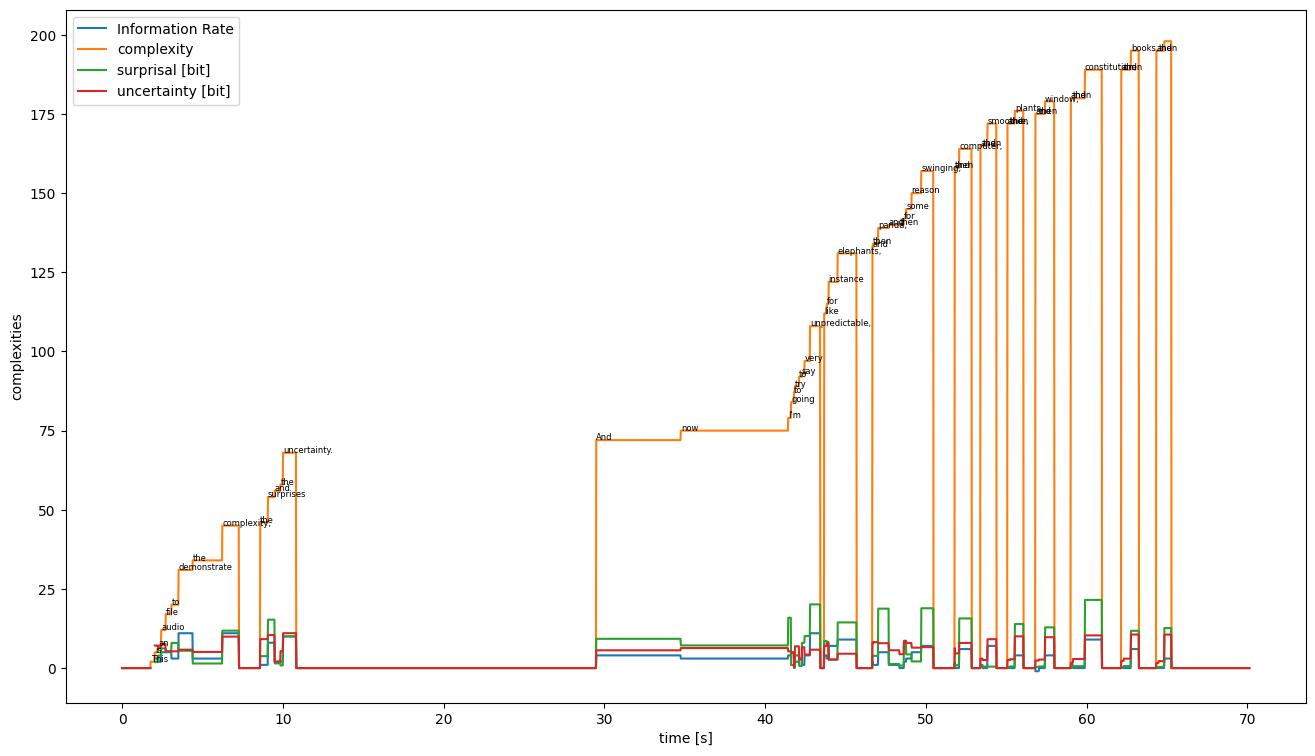

In [ ]:
ORDI = 'pierre'

### DEMO GPT2 TEST
# sentence = "I enjoy walking in the"
# model = LMHeadModel("gpt2")
# list_proba = model.get_next_word_probabilities(sentence, top_k=10)
# print(list_proba)
###



#### DEMO WITH PLOTS FOR TEXT
# text = 'Hello my name is Pierre and I am a PhD student at the University of East London'
# list_gpt, list_entropy = get_GPT_surprisal_text(text)
# plt.plot(list_gpt)
# plt.show()



#### DEMO WITH PLOTS FOR AUDIO
audio_dir = '/content/'
temp_folder = '/content/Temp_Folder/'

# file_name = '1015_1_pk.wav'
file_name = 'Demo-audio.wav'
# file_name = 'Demo-Deutsch.wav'

full_audio_path = os.path.join(audio_dir, file_name)
print("Full audio path:", full_audio_path)

demo_audio_semantic_complexity_pipeline(audio_dir,file_name,temp_folder)

In [ ]:
def generate_text_info_timestamps2(audio_dir,file_name,output_dir):
    device = "cuda"
    batch_size = 8 # reduce if low on GPU mem
    compute_type = "int8" # change to "int8" if low on GPU mem (may reduce accuracy)

    # transcribe with original whisper
    model = whisper.load_model("medium", device)
    result = model.transcribe(audio_dir+file_name,language = 'en')

    print(result["segments"]) # before alignment

    # load alignment model and metadata
    model_a, metadata = whisperx.load_align_model(language_code='en', device=device)

    # align whisper output
    result_aligned = whisperx.align(result["segments"], model_a, metadata, audio_dir+file_name, device)

    print(result_aligned["segments"]) # after alignment
    print(result_aligned["word_segments"]) # after alignment

    result_output = os.path.join(output_dir,file_name[:-4]+'.json')
    with open(result_output,'w') as f:
        json.dump(result_aligned,f)

def json_to_df(input_dir,file_name,out_dir_csv):
    with open(input_dir+file_name) as f:
        d = json.load(f)

    df = pd.DataFrame({
        'filename':[],
        'onset':[],
        'offset':[],
        'text' : [],
        'syllable' : []
        })
    df.to_csv(out_dir_csv+file_name[:-5]+'.csv')
    print('csv output initilased')
    total_segs = d['word_segments']
    nb_segs = len(total_segs)
    print("nb_seg = ", nb_segs)
    print(total_segs)
    for s in range(nb_segs):
        word_info = total_segs[s]
        print(word_info)
        try:
            word = word_info['word']
            onset = word_info['start']
            offset = word_info['end']
            syllable = syllables.estimate(word)
        except:
            word = word_info['word']
            syllable = syllables.estimate(word)
            word_info = total_segs[s-1]
            onset = word_info['end']
            word_info = total_segs[s+1]
            offset = word_info['start']
        row_contents = [0,file_name,
        onset, offset, word, syllable]
        append_list_as_row(out_dir_csv+file_name[:-5]+'.csv', row_contents)


def demo_audio_semantic_complexity_pipeline(audio_dir,file_name,temp_folder):

    ## AUDIO TRANSCRIPTION (can take 20min for 1min file with large model on laptop)
    # generate_text_info_timestamps2(audio_dir,file_name,temp_folder)

    ## FROM JSON format to CSV format
    # json_to_df(temp_folder,file_name[:-4]+'.json',temp_folder)


    ## FROM CSV TRANSCIPTIONS to COMPLEXITY SURPRISAL and UNCERTAINTY ####

    # df_surprisal = get_next_list_dataframe_prompted(temp_folder,file_name[:-4]+'.csv')
    # df_total = pd.read_csv(temp_folder+file_name[:-4]+'.csv')
    # df_total['Complexity'] = df_surprisal['Complexity']
    # # df_total['InfoRate'] = df_surprisal['Complexity'].diff()
    # df_total['Surprisal'] = df_surprisal['Surprisal']
    # df_total['Entropy'] = df_surprisal['Entropy']
    # df_total.to_csv(temp_folder+file_name[:-4]+'.csv')

    # df_total = pd.read_csv(temp_folder+file_name[:-4]+'.csv')
    # df_total['InfoRate'] = df_total['Complexity'].diff()
    # print(df_total['InfoRate'])
    # df_total.to_csv(temp_folder+file_name[:-4]+'.csv')
    df_total = pd.read_csv(temp_folder+file_name[:-4]+'.csv')
    # print(df_total)
    ####


    ## FROM SURPRISAL and UNCERTAINTY to NUMPY TIME SERIES ####
    # path_output_complexity = 'Semantic_outputs/'
    # path_output_InfoRate = 'Semantic_outputs/'
    # path_output_surprisal = 'Semantic_outputs/'
    # path_output_uncertainty = 'Semantic_outputs/'
    # path_output_segment = 'Semantic_outputs/'


    list_complexity,list_InfoRate,list_surprisal, list_uncertainty, list_segment = df_to_numpy(temp_folder,file_name)
    # np.save(path_output_complexity+file_name[:-4]+'_SC.npy',list_complexity)
    # np.save(path_output_complexity+file_name[:-4]+'_IR.npy',list_InfoRate)
    # np.save(path_output_surprisal+file_name[:-4]+'_SS.npy',list_surprisal)
    # np.save(path_output_uncertainty+file_name[:-4]+'_SU.npy',list_uncertainty)
    # np.save(path_output_segment+file_name[:-4]+'_SpSg.npy',list_segment)

    #### PLOTTING ####

    text = df_total['text'].to_numpy()
    df_onset = df_total['onset'].to_numpy()
    df_offset = df_total['offset'].to_numpy()
    df_complexity = df_total['Complexity'].to_numpy()
    # text = " ".join(text)
    time = np.arange(0,len(list_complexity)/50,1/50)

    plt.figure(figsize= (16,9) )
    for k in range(len(text)-1):
        plt.text(df_onset[k],df_complexity[k],text[k],size = 6)

    plt.plot(time,list_InfoRate,label = 'Information Rate')
    plt.plot(time,list_complexity,label = 'complexity')

    plt.plot(time,list_surprisal,label = 'surprisal [bit]')
    plt.plot(time,list_uncertainty,label = 'uncertainty [bit]')
    plt.xlabel('time [s]')
    plt.ylabel('complexities')
    plt.legend()
    plt.savefig(file_name[:-4]+'.svg')
    plt.show()

    plt.figure(figsize= (16,9) )
    plt.title('Dynamic Semantic Complexities')
    plt.subplot(411)
    for k in range(len(text)-1):
        plt.text(df_onset[k],df_complexity[k]+2,text[k],size = 5)

    plt.plot(time,list_complexity,label = 'complexity')
    plt.ylabel('cumulative complexity')
    plt.subplot(412)
    plt.plot(time,list_InfoRate,label = 'Information Rate')
    plt.ylabel('instantaneous complexity')
    plt.subplot(413)
    plt.plot(time,list_surprisal,label = 'surprisal [bit]')
    plt.ylabel('Information Surprisal')
    plt.subplot(414)
    plt.plot(time,list_uncertainty,label = 'uncertainty [bit]')
    plt.xlabel('time [s]')
    plt.ylabel('Information Uncertainty')
    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

    plt.savefig(file_name[:-4]+'_all_4.svg')
    plt.show()




In [ ]:
#### DEMO WITH PLOTS FOR AUDIO
audio_dir = '/content/'
temp_folder = '/content/Temp_Folder/'

file_name = '1015_1_pk.wav'
# file_name = 'Demo-audio.wav'
# file_name = 'Demo-Deutsch.wav'

full_audio_path = os.path.join(audio_dir, file_name)
print("Full audio path:", full_audio_path)

demo_audio_semantic_complexity_pipeline(audio_dir,file_name,temp_folder)

NameError: name 'os' is not defined